In [130]:
# import packages needed for data preprocessing
import re
import csv
import pandas as pd
import numpy as np
from scipy import sparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer,sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

%matplotlib inline

In [119]:
data = pd.read_csv('stocknews/Combined_News_DJIA.csv')

# Using this split criteria, the train/test proportion is nearly 80/20
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

In [189]:
data

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

In [120]:
score = test['Label'].values.sum()/len(test)*100
print("The baseline accuracy for prediction on test set: %.3f" % score,'%')

The baseline accuracy for prediction on test set: 50.794 %


In [121]:
# build up tokenizr to remove stopwords
tokenizer = RegexpTokenizer("[a-zA-Z]+")
lemmatizer = WordNetLemmatizer()

def tokenize (raw_text):
    tokens = []
    stops = set(stopwords.words("english")) 
    sents = sent_tokenize(BeautifulSoup(raw_text, "lxml").get_text())
    
    for sent in sents:
        tokens += tokenizer.tokenize(sent)
     
    tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens if not token in stops] 
    
    return tokens

In [122]:
def roc_plot(y_test, y_pred):
    plt.figure()
    lw = 2
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr,color="orange",lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

# Try different test preprocessing methods
## 1. Bag of words(count words in each headline equally)

In [190]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x)[1:] for x in train.iloc[row,2:27]))

trainvect =CountVectorizer(tokenizer = tokenize, analyzer='word', ngram_range=(2,2))
Trainfeature = trainvect.fit_transform(trainheadlines)

In [191]:
trainvect.get_feature_names()

['aa akistan',
 'aaa credit',
 'aaa rating',
 'aaa seal',
 'aaaw nice',
 'aab bankruptcy',
 'aab resume',
 'aab win',
 'aabo able',
 'aadmi party',
 'aafia disappeared',
 'aafia siddiqui',
 'aali graf',
 'aamer last',
 'aamir khan',
 'aamir murdered',
 'aap circumcision',
 'aap party',
 'aaretz refuse',
 'aariyamma likely',
 'aaron swartz',
 'aasai told',
 'ab northern',
 'ababa ethiopian',
 'aback terrible',
 'abadan ne',
 'aban pearl',
 'abandon child',
 'abandon crimea',
 'abandon currency',
 'abandon davos',
 'abandon decade',
 'abandon dollar',
 'abandon dream',
 'abandon effort',
 'abandon europe',
 'abandon french',
 'abandon full',
 'abandon goal',
 'abandon hosni',
 'abandon illusion',
 'abandon internet',
 'abandon iran',
 'abandon islamic',
 'abandon kid',
 'abandon life',
 'abandon livestock',
 'abandon longstanding',
 'abandon marxism',
 'abandon military',
 'abandon myth',
 'abandon net',
 'abandon north',
 'abandon nuclear',
 'abandon operation',
 'abandon plan',
 'aband

In [192]:
Trainfeature.shape

(1611, 354160)

In [194]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x)[1:] for x in test.iloc[row,2:27]))

Testfeature = trainvect.transform(testheadlines)

In [195]:
len(trainheadlines)

1611

### Try models (SVM, logistic regression, Random Forest, Adaboost, Naive Bayes, Neural Network with 3-splits cross validation for time series on Training data)

In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score

Accuracy from SVM: 53.731 %
Accuracy on test set:  48.68 %


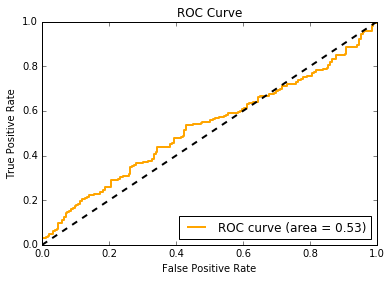

-----
Accuracy from Logistic Regression: 53.648 %
Accuracy on test set:  47.62 %


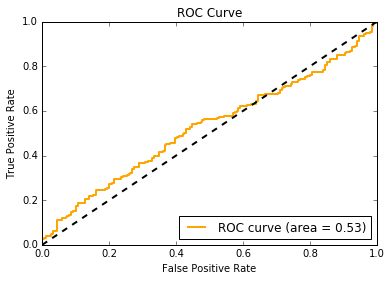

-----
Accuracy from Random Forest: 54.395 %
Accuracy on test set:  50.53 %


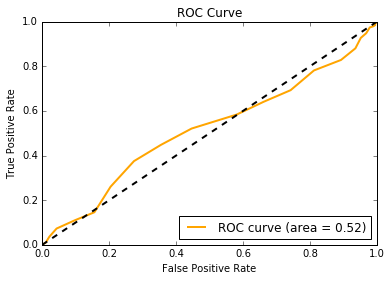

-----
Accuracy from AdaBoost: 51.410 %
Accuracy on test set:  47.62 %


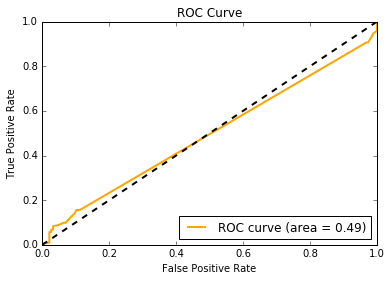

-----
Accuracy from Naive Bayes: 48.922 %
Accuracy on test set:  50.53 %


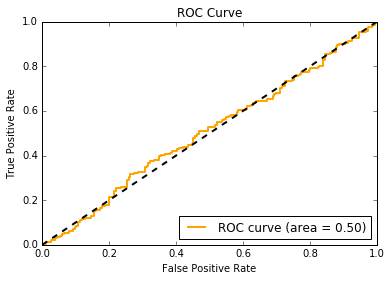

-----


In [197]:
# SVM
SVM = LinearSVC()
Model1 = SVM.fit(Trainfeature,train['Label'])
score = cross_val_score(Model1, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from SVM: %.3f" % score,'%')
pred1 = Model1.predict(Testfeature)
pred1_prob = Model1.decision_function(Testfeature)
score = accuracy_score(test['Label'], pred1)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred1_prob)
print("-----")


# Logistic Regression
logistic = LogisticRegression()
Model2 = logistic.fit(Trainfeature,train['Label'])
score = cross_val_score(Model2, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Logistic Regression: %.3f" % score,'%')
pred2 = Model2.predict(Testfeature)
pred2_prob = Model2.predict_proba(Testfeature)[:, 1]
score = accuracy_score(test['Label'], pred2)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred2_prob)
print("-----")

# Random Forest
RDF = RandomForestClassifier(n_estimators=50,n_jobs=2,oob_score=True)
Model3 = RDF.fit(Trainfeature,train['Label'])
score = cross_val_score(Model3, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Random Forest: %.3f" % score,'%')
pred3 = Model3.predict(Testfeature)
pred3_prob = Model3.predict_proba(Testfeature)[:, 1]
score = accuracy_score(test['Label'], pred3)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred3_prob)
print("-----")

# AdaBoost
adb = AdaBoostClassifier(n_estimators = 30)
Model4 = adb.fit(Trainfeature,train['Label'])
score = cross_val_score(Model4, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from AdaBoost: %.3f" % score,'%')
pred4 = Model4.predict(Testfeature)
pred4_prob = Model4.predict_proba(Testfeature)[:, 1]
score = accuracy_score(test['Label'], pred4)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred4_prob)
print("-----")

# Naive Bayes
NB = MultinomialNB()
Model5 = NB.fit(Trainfeature,train['Label'])
score = cross_val_score(Model5, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Naive Bayes: %.3f" % score,'%')
pred5 = Model5.predict(Testfeature)
pred5_prob = Model5.predict_proba(Testfeature)[:, 1]
score = accuracy_score(test['Label'], pred5)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred5_prob)
print("-----")

In [110]:
# # Neural Network
# NN = MLPClassifier(max_iter = 300)
# Model6 = NN.fit(Trainfeature,train['Label'])
# score = cross_val_score(Model6, Trainfeature, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
# print("Accuracy from Naive Bayes: %.3f" % score,'%')
# print("-----")

## 2. Bag of words(Give top1-5 headlines weight 6, 5, 4, 3, 2, and 1 for the rest)

In [131]:
data_weight = data.copy()
data_weight["Top1"] = data_weight["Top1"].apply(lambda x: x*6)
data_weight["Top2"] = data_weight["Top2"].apply(lambda x: x*5)
data_weight["Top3"] = data_weight["Top3"].apply(lambda x: x*4)
data_weight["Top4"] = data_weight["Top4"].apply(lambda x: x*3)
data_weight["Top5"] = data_weight["Top5"].apply(lambda x: x*2)

In [132]:
train_weight = data_weight[data_weight['Date'] < '2015-01-01']
test_weight = data_weight[data_weight['Date'] > '2014-12-31']

In [133]:
trainheadlines2 = []
for row in range(0,len(train_weight.index)):
    trainheadlines2.append(' '.join(str(x) for x in train_weight.iloc[row,2:27]))
    
trainvect2 = CountVectorizer(tokenizer = tokenize, analyzer='word', ngram_range=(2,2))
Trainfeature2 = trainvect2.fit_transform(trainheadlines2)

In [134]:
Trainfeature2.shape

(1611, 350602)

In [135]:
testheadlines2 = []
for row in range(0,len(test_weight.index)):
    testheadlines2.append(' '.join(str(x) for x in test_weight.iloc[row,2:27]))

Testfeature2 = trainvect2.transform(testheadlines2)

In [136]:
Testfeature2.shape

(378, 350602)

### Try models (SVM, logistic regression, Random Forest, Adaboost, Naive Bayes, Neural Network with 3-splits cross validation for time series on Training data)

Accuracy from SVM: 53.234 %
Accuracy on test set:  48.94 %


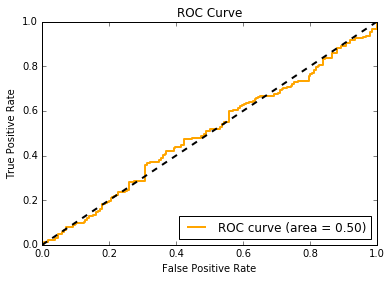

-----
Accuracy from Logistic Regression: 53.317 %
Accuracy on test set:  48.68 %


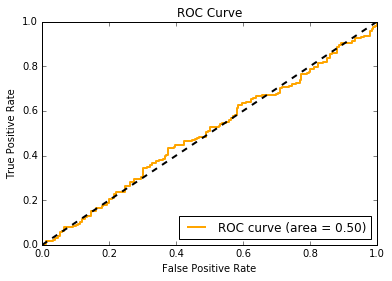

-----
Accuracy from Random Forest: 54.561 %
Accuracy on test set:  51.06 %


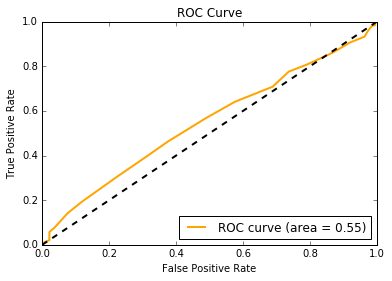

-----
Accuracy from AdaBoost: 54.975 %
Accuracy on test set:  48.41 %


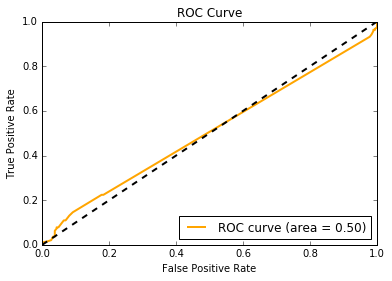

-----
Accuracy from Naive Bayes: 47.181 %
Accuracy on test set:  50.53 %


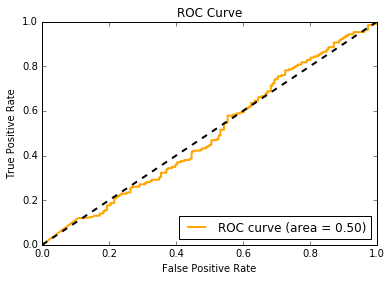

-----


In [137]:
# SVM
SVM = LinearSVC()
Model1 = SVM.fit(Trainfeature2,train_weight['Label'])
score = cross_val_score(Model1, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from SVM: %.3f" % score,'%')
pred1 = Model1.predict(Testfeature2)
pred1_prob = Model1.decision_function(Testfeature2)
score = accuracy_score(test_weight['Label'], pred1)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred1_prob)
print("-----")

# Logistic Regression
logistic = LogisticRegression()
Model2 = logistic.fit(Trainfeature2,train_weight['Label'])
score = cross_val_score(Model2, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Logistic Regression: %.3f" % score,'%')
pred2 = Model2.predict(Testfeature2)
pred2_prob = Model2.predict_proba(Testfeature2)[:, 1]
score = accuracy_score(test_weight['Label'], pred2)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred2_prob)
print("-----")

# Random Forest
RDF = RandomForestClassifier(n_estimators=50,n_jobs=2,oob_score=True)
Model3 = RDF.fit(Trainfeature2,train_weight['Label'])
score = cross_val_score(Model3, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Random Forest: %.3f" % score,'%')
pred3 = Model3.predict(Testfeature2)
pred3_prob = Model3.predict_proba(Testfeature2)[:, 1]
score = accuracy_score(test_weight['Label'], pred3)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred3_prob)
print("-----")

# AdaBoost
adb = AdaBoostClassifier(n_estimators = 30)
Model4 = adb.fit(Trainfeature2,train_weight['Label'])
score = cross_val_score(Model4, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from AdaBoost: %.3f" % score,'%')
pred4 = Model4.predict(Testfeature2)
pred4_prob = Model4.predict_proba(Testfeature2)[:, 1]
score = accuracy_score(test_weight['Label'], pred4)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred4_prob)
print("-----")

# Naive Bayes
NB = MultinomialNB()
Model5 = NB.fit(Trainfeature2,train_weight['Label'])
score = cross_val_score(Model5, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Naive Bayes: %.3f" % score,'%')
pred5 = Model5.predict(Testfeature2)
pred5_prob = Model5.predict_proba(Testfeature2)[:, 1]
score = accuracy_score(test_weight['Label'], pred5)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred5_prob)
print("-----")

In [91]:
# # Neural Network
# NN = MLPClassifier(max_iter = 300)
# Model6 = NN.fit(Trainfeature2,train_weight['Label'])
# score = cross_val_score(Model6, Trainfeature2, train_weight['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
# print("Accuracy from Naive Bayes: %.3f" % score,'%')
# print("-----")

## 3. TfidfVectorizer(without weighted)

In [198]:
trainheadlines = []
for row in range(0,len(train.index)):
    trainheadlines.append(' '.join(str(x)[1:] for x in train.iloc[row,2:27]))

trainvect = TfidfVectorizer(tokenizer = tokenize, analyzer='word', min_df=0.01, max_df=0.99, max_features = 20000, ngram_range = (2, 2))
Trainfeature3 = trainvect.fit_transform(trainheadlines)

In [199]:
trainvect.get_feature_names()

['according new',
 'according report',
 'across country',
 'across europe',
 'african country',
 'african republic',
 'aid ship',
 'air force',
 'air france',
 'air pollution',
 'air strike',
 'aircraft carrier',
 'al assad',
 'al jazeera',
 'al qaeda',
 'al qaida',
 'american country',
 'amnesty international',
 'angela merkel',
 'anti corruption',
 'anti gay',
 'anti government',
 'anti islam',
 'anti piracy',
 'anti terror',
 'arab spring',
 'arab world',
 'armed force',
 'around world',
 'arrest warrant',
 'asylum seeker',
 'attack iran',
 'attack u',
 'audi arabia',
 'austerity measure',
 'australian government',
 'avid cameron',
 'b c',
 'ban ki',
 'bank account',
 'bank settlement',
 'barack obama',
 'barrier reef',
 'bashar al',
 'bay founder',
 'bbc news',
 'bc news',
 'beaten death',
 'become first',
 'becomes first',
 'benjamin netanyahu',
 'big picture',
 'billion dollar',
 'billion euro',
 'bin laden',
 'bird flu',
 'birth control',
 'black market',
 'black sea',
 'blasphe

In [200]:
testheadlines = []
for row in range(0,len(test.index)):
    testheadlines.append(' '.join(str(x)[1:] for x in test.iloc[row,2:27]))

Testfeature3 = trainvect.transform(testheadlines)

In [201]:
Testfeature3.shape

(378, 704)

Accuracy from SVM: 48.96 %
Accuracy on test set:  48.68 %


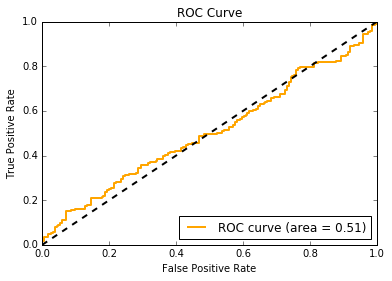

-----
Accuracy from Logistic Regression: 49.10 %
Accuracy on test set:  46.83 %


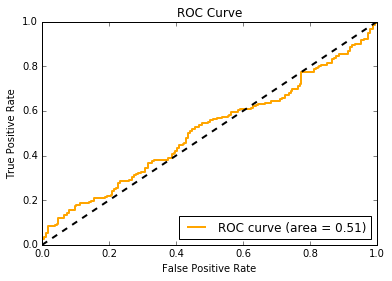

-----
Accuracy from Random Forest: 49.48 %
Accuracy on test set:  50.79 %


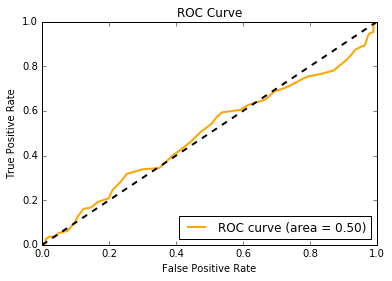

-----
Accuracy from AdaBoost: 49.10 %
Accuracy on test set:  50.00 %


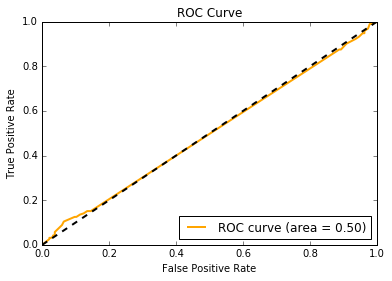

-----
Accuracy from Naive Bayes: 50.22 %
Accuracy on test set:  49.21 %


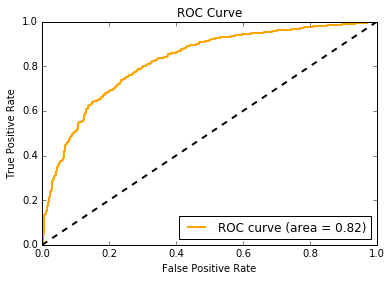

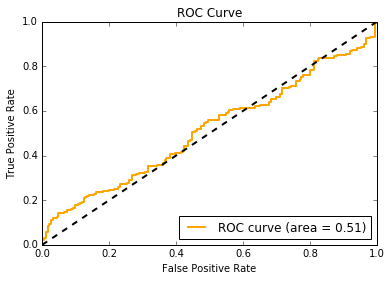

-----


In [202]:
# SVM
SVM = LinearSVC()
Model1 = SVM.fit(Trainfeature3,train['Label'])
score = cross_val_score(Model1, Trainfeature3, train['Label'], cv=TimeSeriesSplit(n_splits=5),n_jobs=-1).mean()*100
print("Accuracy from SVM: %.2f" % score,'%')
pred1 = Model1.predict(Testfeature3)
pred1_prob = Model1.decision_function(Testfeature3)
score = accuracy_score(test['Label'], pred1)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred1_prob)
print("-----")

# Logistic Regression
logistic = LogisticRegression()
Model2 = logistic.fit(Trainfeature3,train['Label'])
score = cross_val_score(Model2, Trainfeature3, train['Label'], cv=TimeSeriesSplit(n_splits=5),n_jobs=-1).mean()*100
print("Accuracy from Logistic Regression: %.2f" % score,'%')
pred2 = Model2.predict(Testfeature3)
pred2_prob = Model2.predict_proba(Testfeature3)[:, 1]
score = accuracy_score(test['Label'], pred2)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred2_prob)
print("-----")

# Random Forest
RDF = RandomForestClassifier(n_estimators=100,n_jobs=2,oob_score=True)
Model3 = RDF.fit(Trainfeature3,train['Label'])
score = cross_val_score(Model3, Trainfeature3, train['Label'], cv=TimeSeriesSplit(n_splits=5),n_jobs=-1).mean()*100
print("Accuracy from Random Forest: %.2f" % score,'%')
pred3 = Model3.predict(Testfeature3)
pred3_prob = Model3.predict_proba(Testfeature3)[:, 1]
score = accuracy_score(test['Label'], pred3)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred3_prob)
print("-----")

# AdaBoost
adb = AdaBoostClassifier(n_estimators = 30)
Model4 = adb.fit(Trainfeature3,train['Label'])
score = cross_val_score(Model4, Trainfeature3, train['Label'], cv=TimeSeriesSplit(n_splits=5),n_jobs=-1).mean()*100
print("Accuracy from AdaBoost: %.2f" % score,'%')
pred4 = Model4.predict(Testfeature3)
pred4_prob = Model4.predict_proba(Testfeature3)[:, 1]
score = accuracy_score(test['Label'], pred4)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred4_prob)
print("-----")

# Naive Bayes
NB = MultinomialNB()
Model5 = NB.fit(Trainfeature3,train['Label'])
score = cross_val_score(Model5, Trainfeature3, train['Label'], cv=TimeSeriesSplit(n_splits=5),n_jobs=-1).mean()*100
print("Accuracy from Naive Bayes: %.2f" % score,'%')
pred5 = Model5.predict(Testfeature3)
pred5_prob_train =Model5.predict_proba(Trainfeature3)[:, 1]
pred5_prob = Model5.predict_proba(Testfeature3)[:, 1]
score = accuracy_score(test['Label'], pred5)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(train['Label'], pred5_prob_train)
roc_plot(test['Label'], pred5_prob)
print("-----")

### Here I tried to select features using random forest and use the most important features to train a SVM model

In [203]:
feature_names = trainvect.get_feature_names()
importances = Model3.feature_importances_
indices = np.argsort(importances)[::-1]
print("feature ranking:")
for f in range(200):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]),feature_names[indices[f]])

feature ranking:
1. feature 693 (0.009448) year old
2. feature 28 (0.008531) around world
3. feature 386 (0.007568) nuclear weapon
4. feature 374 (0.007092) north korea
5. feature 466 (0.006765) prime minister
6. feature 232 (0.006346) human right
7. feature 646 (0.005749) united state
8. feature 626 (0.004893) u n
9. feature 160 (0.004829) first time
10. feature 362 (0.004734) new zealand
11. feature 656 (0.004732) wall street
12. feature 413 (0.004714) orth korea
13. feature 73 (0.004604) catholic church
14. feature 668 (0.004360) west bank
15. feature 46 (0.004351) bc news
16. feature 658 (0.004280) war crime
17. feature 565 (0.004196) suicide bomber
18. feature 405 (0.004169) ong kong
19. feature 365 (0.004030) news international
20. feature 541 (0.004009) south africa
21. feature 375 (0.003982) north korean
22. feature 579 (0.003978) tear gas
23. feature 507 (0.003930) saudi arabia
24. feature 645 (0.003927) united nation
25. feature 526 (0.003841) sexual abuse
26. feature 518 (0.

In [204]:
## choose optimal number of features to use for LinearSVC
for k in range(10,660,50):
    SVM = LinearSVC(class_weight='balanced')
    score = cross_val_score(SVM, Trainfeature3[:][:,indices[0:k]], train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
    print("Use top",k,'important features')
    print("CV Accuracy: ","%.2f" % score,'%')
    print("-----")

Use top 10 important features
CV Accuracy:  51.00 %
-----
Use top 60 important features
CV Accuracy:  56.38 %
-----
Use top 110 important features
CV Accuracy:  56.88 %
-----
Use top 160 important features
CV Accuracy:  56.88 %
-----
Use top 210 important features
CV Accuracy:  57.38 %
-----
Use top 260 important features
CV Accuracy:  55.06 %
-----
Use top 310 important features
CV Accuracy:  54.81 %
-----
Use top 360 important features
CV Accuracy:  53.90 %
-----
Use top 410 important features
CV Accuracy:  53.65 %
-----
Use top 460 important features
CV Accuracy:  54.48 %
-----
Use top 510 important features
CV Accuracy:  54.31 %
-----
Use top 560 important features
CV Accuracy:  53.81 %
-----
Use top 610 important features
CV Accuracy:  53.07 %
-----


In [208]:
# choose optimal c
for c in range(1, 11):
    SVM = LinearSVC(C = c/10, class_weight='balanced')
    score = cross_val_score(SVM, Trainfeature3[:,indices[0:250]], train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
    print("C:",c/10)
    print("CV Accuracy: ","%.2f" % score,'%')
    print("-----")

C: 0.1
CV Accuracy:  53.65 %
-----
C: 0.2
CV Accuracy:  53.90 %
-----
C: 0.3
CV Accuracy:  54.06 %
-----
C: 0.4
CV Accuracy:  54.06 %
-----
C: 0.5
CV Accuracy:  54.56 %
-----
C: 0.6
CV Accuracy:  54.73 %
-----
C: 0.7
CV Accuracy:  55.06 %
-----
C: 0.8
CV Accuracy:  55.06 %
-----
C: 0.9
CV Accuracy:  55.14 %
-----
C: 1.0
CV Accuracy:  55.39 %
-----


Accuracy on test set:  50.79 %


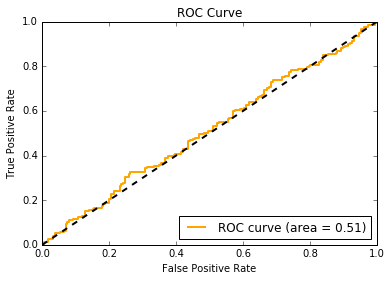

-----


In [209]:
SVM = LinearSVC(C =1.0, class_weight='balanced')
final_model = SVM.fit(Trainfeature3[:,indices[0:250]], train['Label'])
pred = final_model.predict(Testfeature3[:,indices[0:250]])
pred_prob = final_model.decision_function(Testfeature3[:,indices[0:250]])
score = accuracy_score(test['Label'], pred)*100
cm = confusion_matrix(test['Label'], pred)
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred_prob)
print("-----")

Confusion matrix, without normalization
[[ 76 110]
 [ 56 136]]


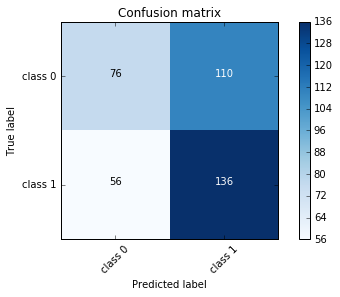

In [188]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 1.5
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm,['class 0','class 1'], title='Confusion matrix')
plt.show()

It givea a best cross validation result using the top 210 features and with a SVM model using C = 0.3. The accuracy on cross validation set is 56.97 % and 57.41 %.

### Do SVD for unimportant features, merge them to 10 features

In [46]:
Trainfeature3[:,indices[160:]].shape

(1611, 497)

In [47]:
svd2 = TruncatedSVD(n_components=20, n_iter=7, random_state=42)
train_rest = svd2.fit_transform(Trainfeature3[:,indices[210:]])
test_rest = svd2.transform(Testfeature3[:,indices[210:]])
print(svd2.explained_variance_ratio_)
train_rest.shape

[ 0.00188252  0.00859925  0.00826605  0.00741313  0.00607053  0.00586579
  0.00557836  0.00546868  0.00540248  0.00528882  0.00526084  0.00520389
  0.00511751  0.00501401  0.00495123  0.00490667  0.00479726  0.00476793
  0.00471973  0.00469289]


(1611, 20)

In [48]:
test_rest.shape

(378, 20)

In [50]:
Trainfeature3[:,indices[:160]].shape

(1611, 160)

In [51]:
train_rest[:,:20].shape

(1611, 20)

In [52]:
Trainfeature4 = sparse.csr_matrix(sparse.hstack((Trainfeature3[:,indices[:160]], train_rest[:,:20])).A)
Testfeature4 = sparse.csr_matrix(sparse.hstack((Testfeature3[:,indices[:160]], test_rest[:,:20])).A)

In [53]:
Trainfeature4.shape

(1611, 180)

Accuracy from SVM: 56.80 %
Accuracy on test set:  53.70 %


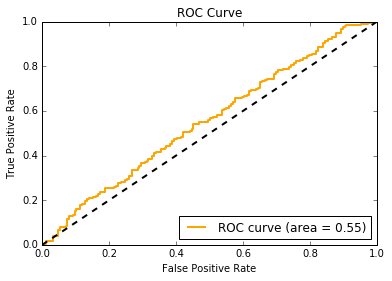

-----
Accuracy from Logistic Regression: 56.72 %
Accuracy on test set:  54.76 %


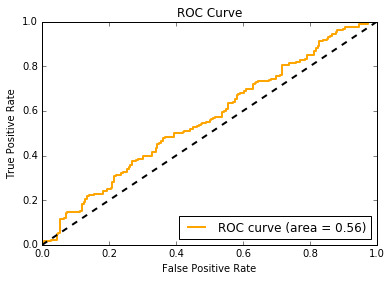

-----
Accuracy from Random Forest: 52.65 %
Accuracy on test set:  51.32 %


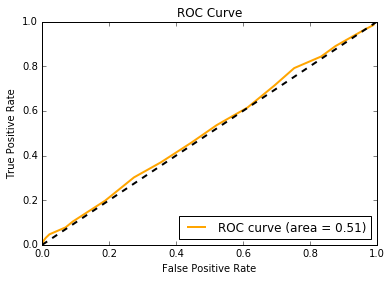

-----
Accuracy from AdaBoost: 53.32 %
Accuracy on test set:  51.06 %


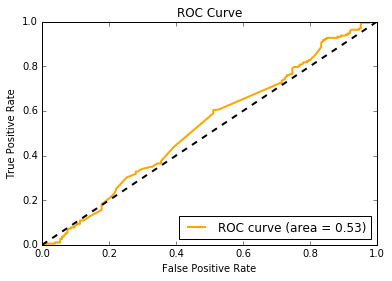

-----


In [55]:
# SVM
SVM = LinearSVC()
Model1 = SVM.fit(Trainfeature4,train['Label'])
score = cross_val_score(Model1, Trainfeature4, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from SVM: %.2f" % score,'%')
pred1 = Model1.predict(Testfeature4)
pred1_prob = Model1.decision_function(Testfeature4)
score = accuracy_score(test['Label'], pred1)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred1_prob)
print("-----")

# Logistic Regression
logistic = LogisticRegression()
Model2 = logistic.fit(Trainfeature4,train['Label'])
score = cross_val_score(Model2, Trainfeature4, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Logistic Regression: %.2f" % score,'%')
pred2 = Model2.predict(Testfeature4)
pred2_prob = Model2.predict_proba(Testfeature4)[:, 1]
score = accuracy_score(test['Label'], pred2)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred2_prob)
print("-----")

# Random Forest
RDF = RandomForestClassifier(n_estimators=50,n_jobs=2,oob_score=True)
Model3 = RDF.fit(Trainfeature4,train['Label'])
score = cross_val_score(Model3, Trainfeature4, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Random Forest: %.2f" % score,'%')
pred3 = Model3.predict(Testfeature4)
pred3_prob = Model3.predict_proba(Testfeature4)[:, 1]
score = accuracy_score(test['Label'], pred3)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred3_prob)
print("-----")

# AdaBoost
adb = AdaBoostClassifier(n_estimators = 30)
Model4 = adb.fit(Trainfeature4,train['Label'])
score = cross_val_score(Model4, Trainfeature4, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from AdaBoost: %.2f" % score,'%')
pred4 = Model4.predict(Testfeature4)
pred4_prob = Model4.predict_proba(Testfeature4)[:, 1]
score = accuracy_score(test['Label'], pred4)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred4_prob)
print("-----")

## 4. LSA

In [60]:
from sklearn.decomposition import TruncatedSVD

In [61]:
svd = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
train_lsa = svd.fit_transform(Trainfeature3)
test_lsa = svd.transform(Testfeature3)

In [62]:
train_lsa.shape

(1611, 100)

Accuracy from SVM: 52.57 %
Accuracy on test set:  55.29 %


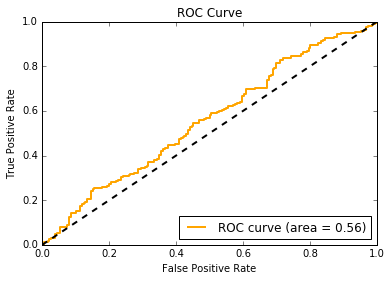

-----
Accuracy from Logistic Regression: 54.39 %
Accuracy on test set:  56.08 %


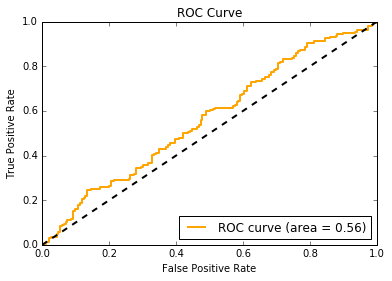

-----
Accuracy from Random Forest: 51.91 %
Accuracy on test set:  50.53 %


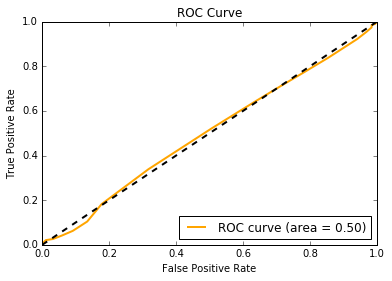

-----
Accuracy from AdaBoost: 49.59 %
Accuracy on test set:  48.68 %


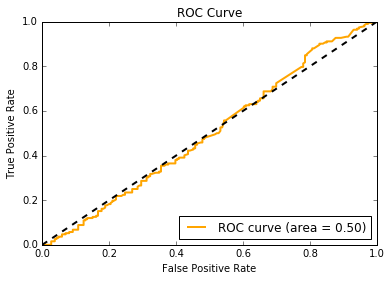

-----


In [63]:
# SVM
SVM = LinearSVC()
Model1 = SVM.fit(train_lsa,train['Label'])
score = cross_val_score(Model1, train_lsa, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from SVM: %.2f" % score,'%')
pred1 = Model1.predict(test_lsa)
pred1_prob = Model1.decision_function(test_lsa)
score = accuracy_score(test['Label'], pred1)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred1_prob)
print("-----")

# Logistic Regression
logistic = LogisticRegression()
Model2 = logistic.fit(train_lsa,train['Label'])
score = cross_val_score(Model2, train_lsa, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Logistic Regression: %.2f" % score,'%')
pred2 = Model2.predict(test_lsa)
pred2_prob = Model2.predict_proba(test_lsa)[:, 1]
score = accuracy_score(test['Label'], pred2)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred2_prob)
print("-----")

# Random Forest
RDF = RandomForestClassifier(n_estimators=50,n_jobs=2,oob_score=True)
Model3 = RDF.fit(train_lsa,train['Label'])
score = cross_val_score(Model3, train_lsa, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from Random Forest: %.2f" % score,'%')
pred3 = Model3.predict(test_lsa)
pred3_prob = Model3.predict_proba(test_lsa)[:, 1]
score = accuracy_score(test['Label'], pred3)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred3_prob)
print("-----")

# AdaBoost
adb = AdaBoostClassifier(n_estimators = 30)
Model4 = adb.fit(train_lsa,train['Label'])
score = cross_val_score(Model4, train_lsa, train['Label'], cv=TimeSeriesSplit(n_splits=3),n_jobs=-1).mean()*100
print("Accuracy from AdaBoost: %.2f" % score,'%')
pred4 = Model4.predict(test_lsa)
pred4_prob = Model4.predict_proba(test_lsa)[:, 1]
score = accuracy_score(test['Label'], pred4)*100
print("Accuracy on test set: ","%.2f" % score,'%')
roc_plot(test['Label'], pred4_prob)
print("-----")